## Financial Stock Analysis
**Matthew Bates & Sankeerti Haniyur.** 
*Final project for STA 148B 'Data Science', Winter 2017*

The functions demonstrated in this notebook can be used to download stock price data from Yahoo Finance, calculate n-day trailing percent or log returns, and plot the results of those calculations. These functions will all be defined first and then demonstrated once, together at the bottom of the page. Having all of this code defined in separate functions will make it easy to import later as a package from a .py file without needed to clutter the markdown file.  This markdown files demonstrate their development and use.

For theory on why the lognormal distribution is often used to describe stock returns, see discussions here [here](https://quantivity.wordpress.com/2011/02/21/why-log-returns/), [here](www.insight-things.com/log-normal-distribution-mistaken), [here](http://stats.stackexchange.com/questions/125761/why-stock-prices-are-lognormal-but-stock-returns-are-normal), & [here](https://www.quora.com/Why-do-people-use-log-returns-of-stock-prices-for-autoregression). (Note, the lognormal distribution is a useful but imperfect since actual returns are still leptokurtic, as shown in the plots at bottom.)

First, we need to import the pakages that we will use.

In [1]:
#Import packages
import urllib                               #for making web requests
import numpy as np                          #for data arrays and processing
import matplotlib.mlab as mlab              #for fitting the best Gaussian curve
import matplotlib.pyplot as plt             #for plotting histograms and curves
import datetime as DT                       #for manipulating datetimes
from matplotlib.dates import date2num       #for plotting datetimes
from matplotlib.dates import DateFormatter  #for plotting datetimes
%matplotlib inline 
plt.style.use('ggplot')                     #set ploting style

Now, let's create a function that can download a time series of adjusted closing prices for publicly traded stocks.

In [2]:
def getYahooFinanceStockData(stock = '^GSPC', fromEarliestYear = 1960):
    '''
    Description: Function to get historical stock data from Yahoo Finance
    Input: a string with the stock symbol (in the format known to Yahoo Finance; defaults to the symbol for the S&P 500;
     also an integer for the staring four-digit year from which to pull data from then until present (defaults to 1960).
    Output: a numpy array of string dates (for market closing events), a list of real number adjusted closing prices on those dates.
    Note: the returned dates and prices are indexed from 0 = most recent clsoing price to max = earliest closing price available or found in period.'''

    #build the url and read the full contents as a string (going back in time upto start of specified year)
    url = 'http://ichart.finance.yahoo.com/table.csv?s=' + stock + '&a=0&b=1&c='+str(fromEarliestYear)
    fulltext = urllib.request.urlopen(url).read().decode('utf-8')
  
    #split the fulltext into individual lines based on the newline character
    fulltextlines = fulltext.splitlines()

    #split the lines into headers and an array of data, based by comma characters
    header = fulltextlines[0].split(',')    #for now, fine to just discard the header...
    data = np.array([line.split(',') for line in fulltextlines[1:]])
  
    #note, if you wanted to return reported closing values instead of adjusted closing values, use column data[4] instead of data[6].
    adjustedClosingPrices = data[:,6]
    closing_dates = data[:,0]
  
    return closing_dates, adjustedClosingPrices

Next, let's define a function that calculates lognormal stock returns for each closing date in. a time series, over the past *n* days.

In [3]:
def calcLogNormalStockReturns(stockPrices = [], n_days=1):   
    '''
    Description: calcualtes the lognormal return from a specified stock over n days; is an alternative to fn: calcPercentStockReturns().
    Input: a list of real number stock prices over time (defaults to an empty list); and an integer 
     for the number of days difference in the past to use in calculating the trailing returns (defaults to one day prior)
    Output: a list of real numbers for lognormal stock returns over the previous n days, for each day in the initial list.
    Note: there are an avg of 5 trading days per week, 21 trading days per month, 252 trading days per year.'''

    #COMPUTE THE N-DAY TRAILING PERCENT RETURNS  
    n_day_lognormal_returns = []
    for i in range(len(stockPrices) - n_days):      #n-day training return; use "-n" to omit oldest n days that won't have a pair with which to compare
        n_day_lognormal_returns.append(np.log(float(stockPrices[i]) / float(stockPrices[i+n_days])))
  
    return n_day_lognormal_returns

Let's also give ourselves the ability to generate a time series of percent returns (which should be almost identical, just in case we will ever want that.

In [4]:
def calcPercentStockReturns(stockPrices = [], n_days=1):   
    '''
    Description: calcualtes the percent return from a specified stock over n days
    Input: a list of real number stock prices over time (defaults to an empty list); and an integer 
     for the number of days difference in the past to use in calculating the trailing returns (defaults to one day prior)
    Output: a list of real numbers for the percent returns over the previous n days, for each day in the initial list.
    Note: there are an avg of 5 trading days per week, 21 trading days per month, 252 trading days per year.'''

    #COMPUTE THE N-DAY TRAILING PERCENT RETURNS
    n_day_percent_returns = []
    for i in range(len(stockPrices) - n_days):     #n-day training return; use "-n" to omit oldest n days that won't have a pair with which to compare
        n_day_percent_returns.append((float(stockPrices[i]) - float(stockPrices[i+n_days])) / float(stockPrices[i+n_days]) *100)
  
    return n_day_percent_returns

Next, let's create a function that can plot the time series of stock adjusted closing prices, calculated lognormal or percent returns, and plot a histogram and gaussian curve of best fit for the resulting distributions. 

In [5]:
def plotStockReturns(stock_name, closing_dates, stock_prices, stock_returns, n_days, isLognormal):

    ## PLOT STOCK ADJUSTED CLOSING PRICE HISTORY ##
    pltdata = []
    for i in range(len(stock_prices)):
        pltdata.append((DT.datetime.strptime(closing_dates[i], "%Y-%m-%d"), stock_prices[i]))
                
    x = [date2num(date) for (date, value) in pltdata]
    y = [value for (date, value) in pltdata]
  
    fig, ax = plt.subplots()
    ax.plot(x,y, linewidth=0.5)
    ax.xaxis.set_major_formatter(DateFormatter('%d %b %Y')) #('%b %d %Y'))
    ax.xaxis_date()  #tell matplotlib to interpret the x-axis values as dates
    plt.gcf().autofmt_xdate(rotation=45) #rotate the x labels
    plt.title('Stock ' + stock_name + ': adjusted closing price')  
    plt.ylabel('adjusted closing price ($)')
    plt.xlabel('dates prior to the present')
    plt.show()


    ## PLOT STOCK CALCUALTED N-DAY PERCENT TRAILING RETURNS ##
    pltdata = []
    for i in range(len(stock_returns)):
        pltdata.append((DT.datetime.strptime(closing_dates[i], "%Y-%m-%d"), stock_returns[i]))
                
    x = [date2num(date) for (date, value) in pltdata]
    y = [value for (date, value) in pltdata]
  
    fig, ax = plt.subplots()
    ax.plot(x,y, linewidth=0.5)
    ax.xaxis.set_major_formatter(DateFormatter('%d %b %Y')) #('%b %d %Y'))
    ax.xaxis_date()  #tell matplotlib to interpret the x-axis values as dates
    plt.gcf().autofmt_xdate(rotation=45) #rotate the x labels
    if isLognormal:
        plt.title('Stock ' + stock_name + ': '+ str(n_days) +'-day trailing returns (lognormal)'
        + '\n(greatest lognormal drawdown in this period was ' + '%.2f' % min(stock_returns) +')')  
        plt.ylabel(str(n_days) + '-day lognormal return')
    else:
        plt.title('Stock ' + stock_name + ': '+ str(n_days) +'-day trailing returns (%)'
        + '\n(greatest percent drawdown in this period was ' + '%.2f' % min(stock_returns) + '%)')  
        plt.ylabel(str(n_days) + '-day percent return')
    plt.xlabel('dates prior to the present')
    plt.show()


    ## PLOT THE HISTOGRAM FOR THE RETURNS DATA AND A GAUSSIAN CURVE OF BEST FIT ##
    #generate the histogram and save the parameters for our line of best fit.
    n, bins, patches = plt.hist(stock_returns, bins=100, normed=True, alpha=0.4)
  
    #generate the Gaussian line of best fit for the histogram.
    y = mlab.normpdf(bins, np.mean(stock_returns), np.std(stock_returns, ddof=1))
    l = plt.plot(bins, y, 'r--', linewidth=2)
  
    #add labels and plot the histogram and Gaussian line of best fit.
    plt.title("Stock: " + stock_name + ": histogram and Gaussian curve of best fit")
    if isLognormal:
        plt.xlabel("bins for lognormal " + str(n_days) + "-day returns")
    else:
        plt.xlabel("bins for percent " + str(n_days) + "-day returns")      
        plt.ylabel("relative proportion of returns within each bin")
        #plt.axis([-.25, .25, 0, 1])
    plt.grid(True)
    plt.show()
  
    if isLognormal:
        print("Mean  of distribution of", n_days, "-day lognormal returns:", np.mean(stock_returns))
        print("StDev of distribution of", n_days, "-day lognormal returns:", np.std(stock_returns, ddof=1), "\n")
    else:
        print("Mean  of distribution of", n_days, "-day percent returns:", np.mean(stock_returns))
        print("StDev of distribution of", n_days, "-day percent returns:", np.std(stock_returns, ddof=1), "\n")


Now let's actually demonstrate the code above for a handful of sample stock symbols. (Notice that stock prices are all leptokurtic (i.e., the distribution shown by the histograms is narrower near the mean than its Gaussian of best of fit, and correspondingly also has fatter tails.)


Test results for LOGNORMAL stock returns (method most likely to be used):


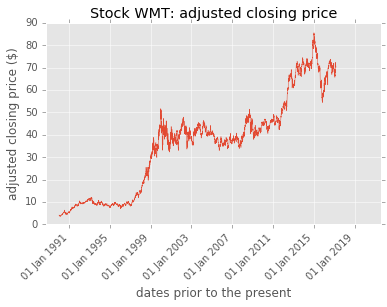

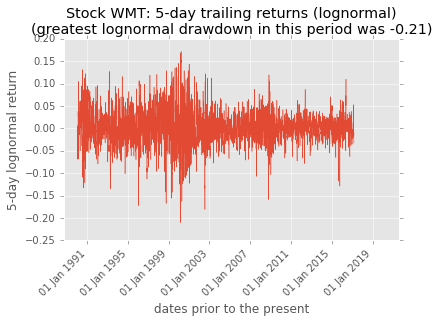

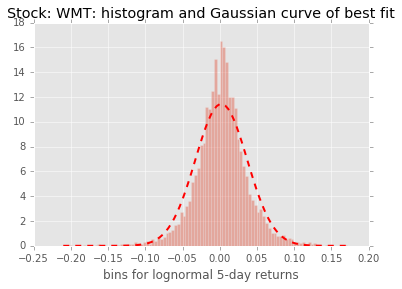

Mean  of distribution of 5 -day lognormal returns: 0.00207827631204
StDev of distribution of 5 -day lognormal returns: 0.0348712018909 



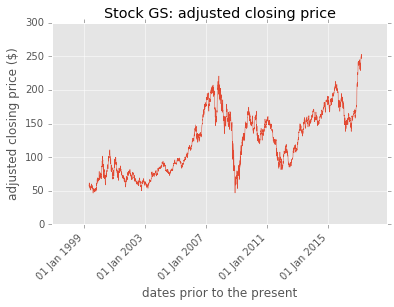

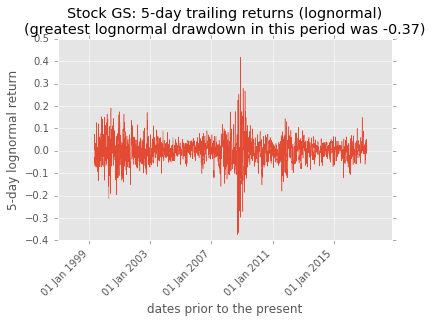

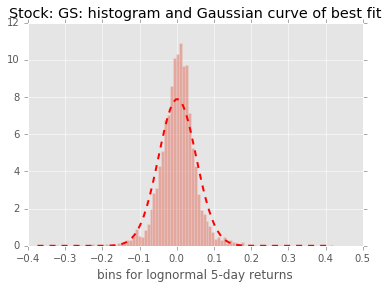

Mean  of distribution of 5 -day lognormal returns: 0.00161869860673
StDev of distribution of 5 -day lognormal returns: 0.050490944863 



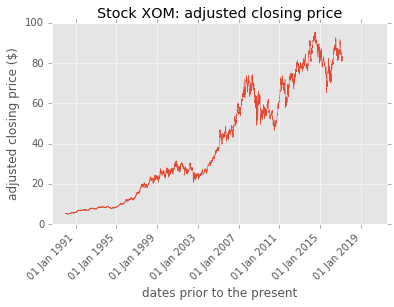

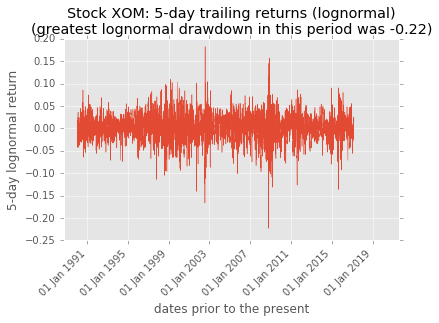

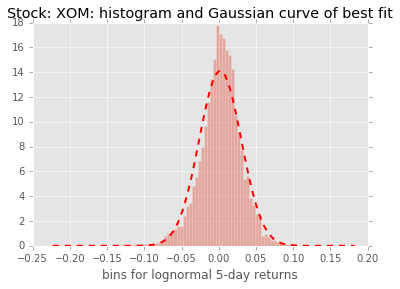

Mean  of distribution of 5 -day lognormal returns: 0.00198279987963
StDev of distribution of 5 -day lognormal returns: 0.0282622187417 



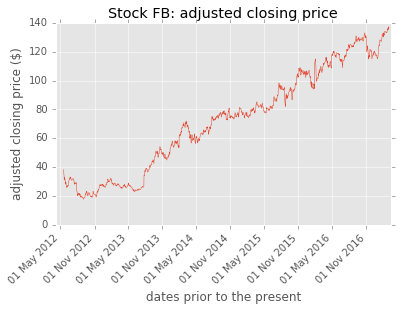

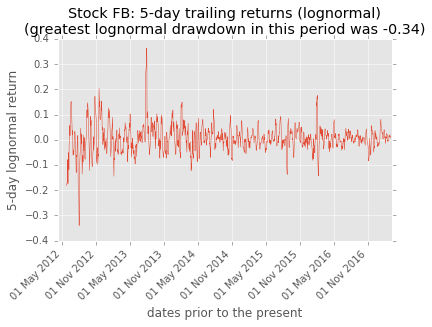

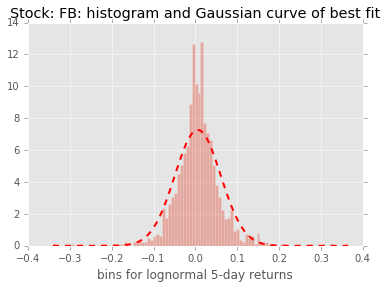

Mean  of distribution of 5 -day lognormal returns: 0.00584951664318
StDev of distribution of 5 -day lognormal returns: 0.0548056676867 



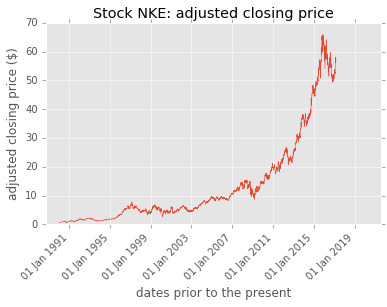

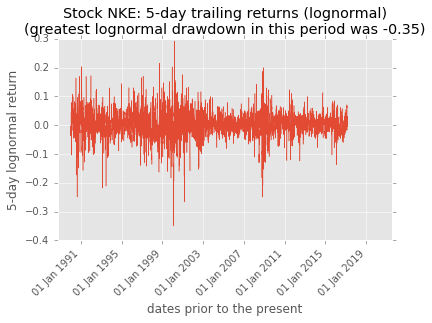

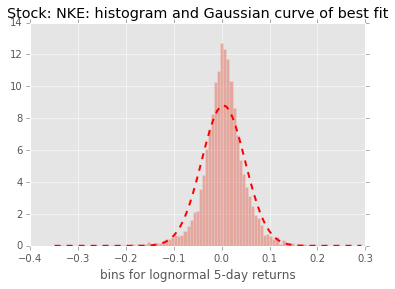

Mean  of distribution of 5 -day lognormal returns: 0.00322916186743
StDev of distribution of 5 -day lognormal returns: 0.045238113898 


------------------------------------------------------


------------------------------------------------------
Test results for stock PERCENT returns (similar, less likely to be used):


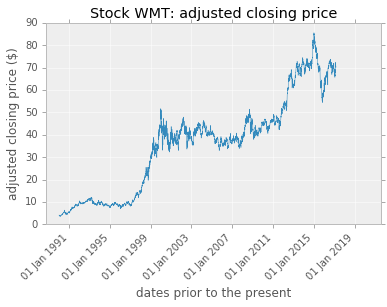

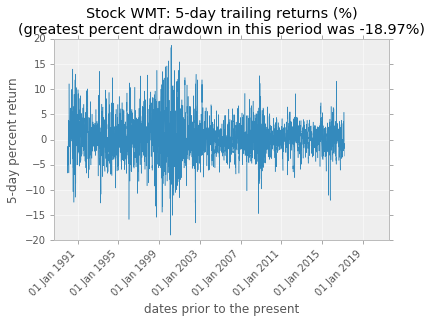

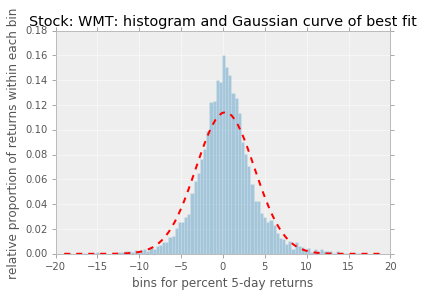

Mean  of distribution of 5 -day percent returns: 0.268906168154
StDev of distribution of 5 -day percent returns: 3.49296471604 



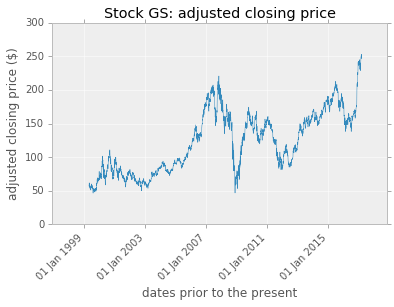

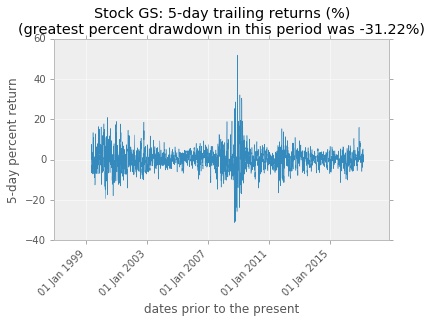

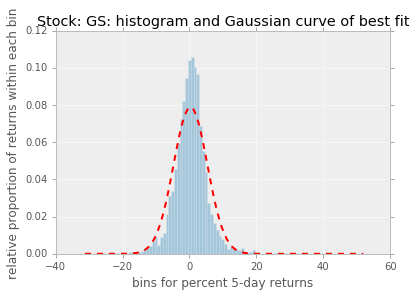

Mean  of distribution of 5 -day percent returns: 0.289346626991
StDev of distribution of 5 -day percent returns: 5.05718834462 



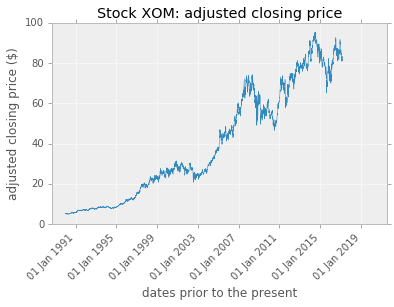

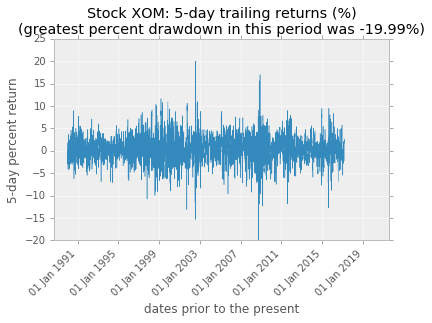

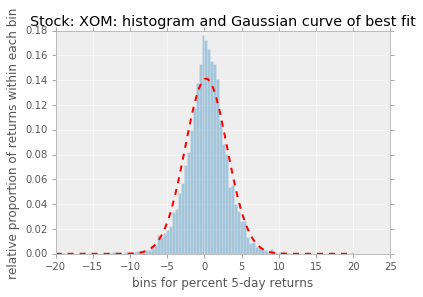

Mean  of distribution of 5 -day percent returns: 0.238361054386
StDev of distribution of 5 -day percent returns: 2.82029314496 



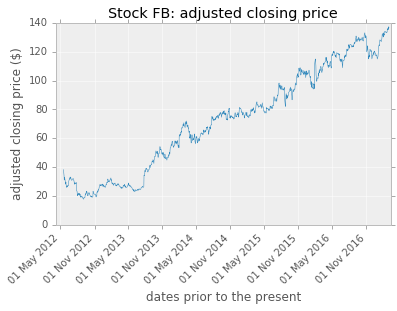

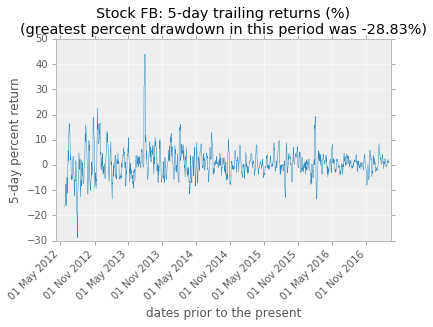

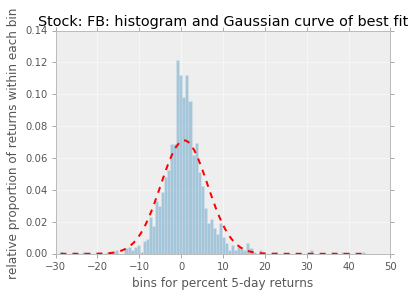

Mean  of distribution of 5 -day percent returns: 0.738760547319
StDev of distribution of 5 -day percent returns: 5.60199411446 



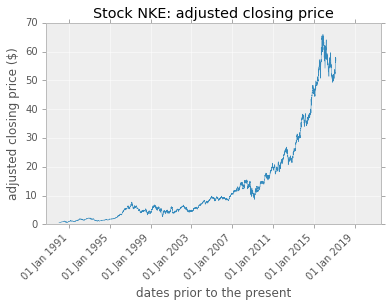

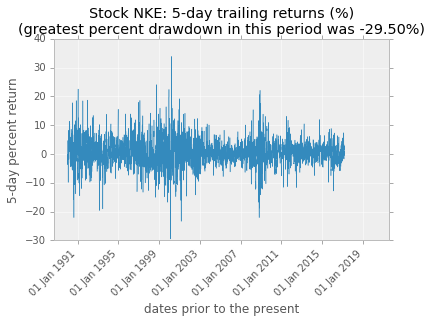

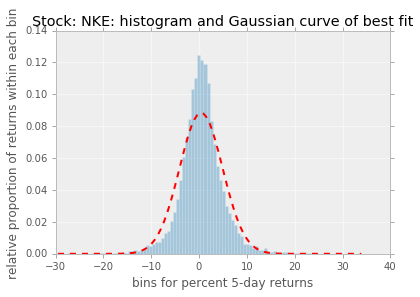

Mean  of distribution of 5 -day percent returns: 0.425498512329
StDev of distribution of 5 -day percent returns: 4.51040829538 



In [19]:
##### TEST IT FOR SOME SAMPLE STOCKS #####
def testStockFunctions():
    '''Description: test the functions created for pulling and analyzing stock data for handful of example stocks. Uses fixed test parameters.'''
    stocks=['WMT','GS','XOM','FB','NKE']
    n_days = 5
    year = 1990
  
    print('\nTest results for LOGNORMAL stock returns (method most likely to be used):')
    plt.style.use('ggplot')                     #set ploting style
    for stock in stocks:  
        closing_dates, stock_prices = getYahooFinanceStockData(stock, year)
        stock_returns = calcLogNormalStockReturns(stock_prices, n_days)
        plotStockReturns(stock, closing_dates, stock_prices, stock_returns, n_days, True)
  
    print('\n------------------------------------------------------\n\n\n------------------------------------------------------')
    plt.style.use('bmh')                        #set ploting style
    print('Test results for stock PERCENT returns (similar, less likely to be used):')
    for stock in stocks:  
        closing_dates, stock_prices = getYahooFinanceStockData(stock, year)
        stock_returns = calcPercentStockReturns(stock_prices, n_days)
        plotStockReturns(stock, closing_dates, stock_prices, stock_returns, n_days, False)

        
testStockFunctions()